# Trabajo LC

Jaume Ivars Grimalt y Iñaki Diez Lambies

#### Importaciones necesarias

In [13]:
import nltk
from nltk.corpus import cess_esp
from nltk.tag import hmm, tnt, AffixTagger, brill, brill_trainer, UnigramTagger, PerceptronTagger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
import scipy.stats as stats
from IPython.display import display
from sklearn.model_selection import train_test_split

nltk.download("cess_esp")
cess_sents = list(cess_esp.tagged_sents())
np.random.shuffle(cess_sents)

[nltk_data] Downloading package cess_esp to /home/jaume/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


## Ejercicio 1

Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de
categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada
sobre 10 particiones del corpus. Barajar el corpus antes de realizar las particiones. Presentar los
resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

In [14]:
def show_accuracy_table(accuracies, title, labels, show_mean=True, show_ic=True):
    mean_acc = np.mean(accuracies)
    conf_int = stats.t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    
    data = {
        title: labels,
        "Accuracy": accuracies
    }

    if show_mean:
        data[title] += ["Mean"]
        data["Accuracy"] = data["Accuracy"] + [mean_acc]

    if show_ic:
        data[title] += ["Confidence interval"]
        data["Accuracy"] = data["Accuracy"] + [f"{conf_int[0]:.4f} - {conf_int[1]:.4f}"]

    df = pd.DataFrame(data)
    display(df)

In [15]:
def show_accuracy_graph(accuracies, title, labels, x_label, show_error_bars=True):
    plt.figure(figsize=(10, 5))

    acc_mean = np.mean(accuracies)
    plt.ylim(max(0, min(accuracies - (accuracies - acc_mean / 2.0))), min(1, max(accuracies + (accuracies - acc_mean / 2.0))))
    
    x = list(range(len(accuracies)))
    plt.plot(x, accuracies, 'ro-')
    
    plt.xticks(x, labels)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    
    if show_error_bars:
        conf_int = stats.t.interval(0.95, len(accuracies) - 1, loc=acc_mean, scale=stats.sem(accuracies))
        error_y = (conf_int[1] - conf_int[0]) / 2
        plt.errorbar(x, accuracies, yerr=error_y, linestyle='None', color='blue', capsize=5)
    
    plt.grid(True)
    plt.show()


In [21]:
def cross_validate_hmm(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partition in enumerate(partitions) if part_idx != i for sentence in partition]

        trainer = hmm.HiddenMarkovModelTagger
        hmm_tagger = trainer.train(train_data)
        acc = hmm_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

### Con todas las categorías

Realizar experimentos

In [22]:
all_categories_accuracies = cross_validate_hmm(cess_sents, 10)

Accuracy for partition 0: 0.898022837809262


KeyboardInterrupt: 

Mostrar resultados

,Accuracy por fold,Accuracy
0,Fold 0,0.299072
1,Fold 1,0.269302
2,Fold 2,0.26768
3,Fold 3,0.266148
4,Fold 4,0.279027
5,Fold 5,0.269685
6,Fold 6,0.289036
7,Fold 7,0.277789
8,Fold 8,0.282163
9,Fold 9,0.286332


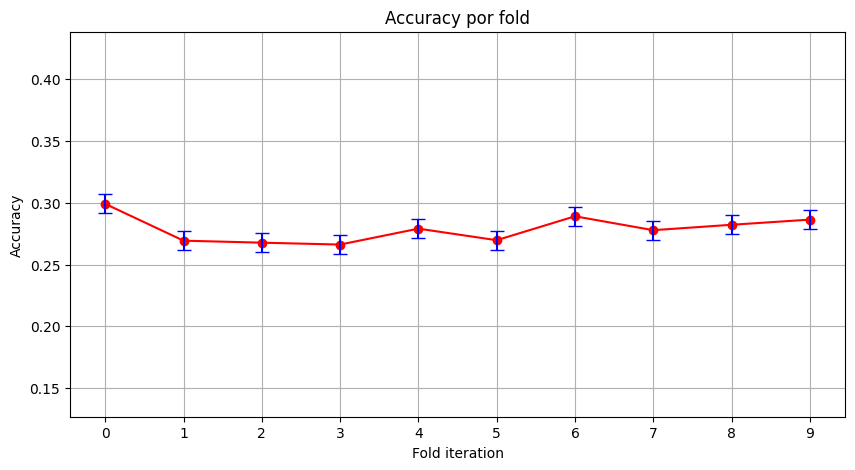

In [6]:
show_accuracy_table(all_categories_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(all_categories_accuracies, "Accuracy por fold", list(range(10)), "Fold iteration")

### Juego de categorías reducido
Preprocesado para reducir las categorías

In [93]:
reduced_cess_sents = []
for sentence in cess_sents:
    new_line = []
    for word, key in sentence:
        if word == "*0*" and key == "sn":
            continue
        elif key[0] == 'v' or key[0] == 'F':
            key = key[:3]
        else:
            key = key[:2]
        new_line.append((word,key))
    reduced_cess_sents.append(new_line)

Realizar experimento

In [16]:
reduced_categories_accuracies = cross_validate_hmm(reduced_cess_sents, 10)

c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy for partition 0: 0.36914932648461657
Accuracy for partition 1: 0.3044818475388981
Accuracy for partition 2: 0.30947035411776713
Accuracy for partition 3: 0.30261666838364065
Accuracy for partition 4: 0.31778274196062134
Accuracy for partition 5: 0.3027697665560211
Accuracy for partition 6: 0.3232081556225944
Accuracy for partition 7: 0.31261643552059615
Accuracy for partition 8: 0.3192440039032407
Accuracy for partition 9: 0.3204754186925986
Mean accuracy:  0.31818147187805945
Confidence interval:  (0.3042695494928558, 0.3320933942632631)


Mostrar resultados

,Accuracy por fold,Accuracy
0,Fold 0,0.369149
1,Fold 1,0.304482
2,Fold 2,0.30947
3,Fold 3,0.302617
4,Fold 4,0.317783
5,Fold 5,0.30277
6,Fold 6,0.323208
7,Fold 7,0.312616
8,Fold 8,0.319244
9,Fold 9,0.320475


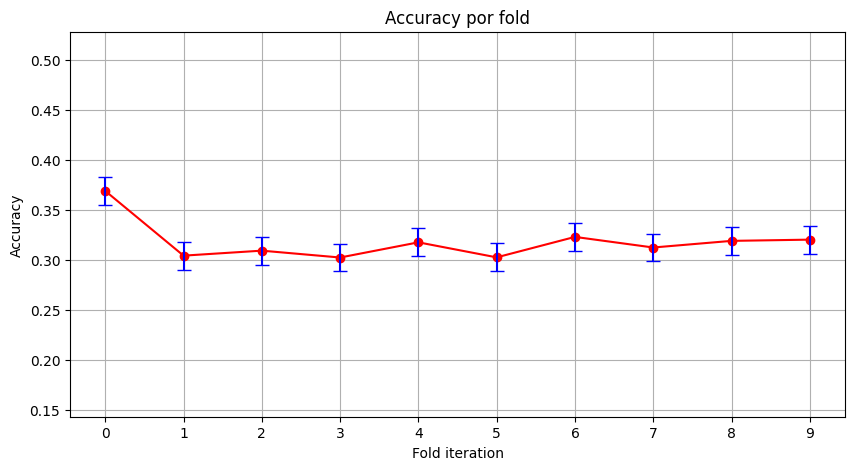

In [18]:
show_accuracy_table(reduced_categories_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(10)])
show_accuracy_graph(reduced_categories_accuracies, "Accuracy por fold", list(range(10)), "Fold iteration")

## Ejercicio 2

Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de 
aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del
corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes
de tamaño similar. La partición 10 se tomará como test, y las 9 particiones restantes se tomarán
como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus
de entrenamiento, manteniendo fija la partición de test.
Importante: Para esta tarea no es necesario realizar la validación cruzada. 

In [10]:
def accumulated_validation(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    train_data = []
    test_data = partitions[-1]

    accuracies = []
    for i in range(num_partitions-1):
        train_data += partitions[i]

        classifier = hmm.HiddenMarkovModelTagger()
        hmm_tagger = classifier.train(train_data)
        acc = hmm_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

Realizar experimentos

In [11]:
accumulated_categories_accuracies = accumulated_validation(cess_sents, 10)

c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:334: RuntimeWarning: overflow encountered in cast
  X[i, j] = self._transitions[si].logprob(self._states[j])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:336: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:332: RuntimeWarning: overflow encountered in cast
  P[i] = self._priors.logprob(si)
c:\MUIARFID\LC\Treball_LC\.venv\Lib\site-packages\nltk\tag\hmm.py:364: RuntimeWarning: overflow encountered in cast
  O[i, k] = self._output_logprob(si, self._symbols[k])


Accuracy for partition 0: 0.044408427876823336
Accuracy for partition 1: 0.09324689357104268
Accuracy for partition 2: 0.13144246353322528
Accuracy for partition 3: 0.16639654240950838
Accuracy for partition 4: 0.1930848190167477
Accuracy for partition 5: 0.21858454889249054
Accuracy for partition 6: 0.2439222042139384
Accuracy for partition 7: 0.26704484062668826
Accuracy for partition 8: 0.2863317125877904
Mean accuracy:  0.18271805030313945
Confidence interval:  (0.1201430657302017, 0.2452930348760772)


Mostrar resultados

,Accuracy por number of partitions,Accuracy
0,Number of partitions 1,0.044408
1,Number of partitions 2,0.093247
2,Number of partitions 3,0.131442
3,Number of partitions 4,0.166397
4,Number of partitions 5,0.193085
5,Number of partitions 6,0.218585
6,Number of partitions 7,0.243922
7,Number of partitions 8,0.267045
8,Number of partitions 9,0.286332
9,Media,0.182718


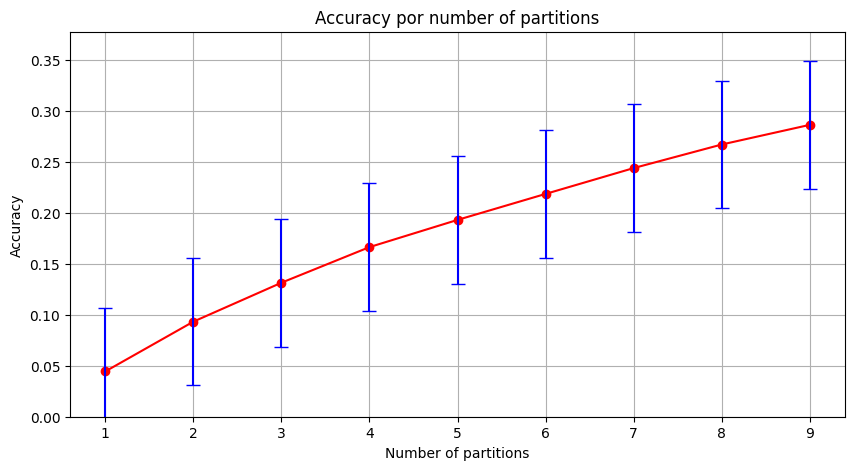

In [14]:
show_accuracy_table(accumulated_categories_accuracies, "Accuracy por number of partitions", ["Number of partitions " + str(i) for i in range(1, 10)], False)
show_accuracy_graph(accumulated_categories_accuracies, "Accuracy por number of partitions", list(range(1, 10)), "Number of partitions", False)

## Ejercicio 3

Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas. 
Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras 
desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría 
morfosintáctica. Este método funciona razonablemente bien para el inglés.

En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en 
cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo 
que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y 
comprobar si aumenta sus prestaciones.

In [76]:
def validate_tnt_suffixes(sentences, affix_length):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    if affix_length != 0:
        tagger = AffixTagger(train_data, affix_length=affix_length)
    else:
        tagger = tnt.TnT()
        tagger.train(train_data)
    
    accuracy = tagger.accuracy(test_data)

    if affix_length != 0:
        print(f"Accuracy for {affix_length} affix length: {accuracy}")
    else:
        print(f"Accuracy for TnT: {accuracy}")

    return accuracy, tagger

Evaluar diferentes longitudes de sufijo

In [77]:
suffix_lengths = range(10)

suffix_accuracies = []
suffix_models = []
for suffix_length in suffix_lengths:
    acc, model = validate_tnt_suffixes(cess_sents, suffix_length)
    suffix_accuracies.append(acc)
    suffix_models.append(model)

Accuracy for TnT: 0.7556215822514075
Accuracy for 1 affix length: 0.16543218402711835
Accuracy for 2 affix length: 0.12234309045153785
Accuracy for 3 affix length: 0.1294867957543803
Accuracy for 4 affix length: 0.1111905489474807
Accuracy for 5 affix length: 0.08734371927876663
Accuracy for 6 affix length: 0.06037296976745525
Accuracy for 7 affix length: 0.04280364139202581
Accuracy for 8 affix length: 0.027578885420693394
Accuracy for 9 affix length: 0.01736718953115521


Etiquetador TNT con el mejor sufijo encontrado

Best suffix length: 1


,Accuracy per suffix,Accuracy
0,Base TNT,0.755622
1,1 suffixes,0.165432
2,2 suffixes,0.122343
3,3 suffixes,0.129487
4,4 suffixes,0.111191
5,5 suffixes,0.087344
6,6 suffixes,0.060373
7,7 suffixes,0.042804
8,8 suffixes,0.027579
9,9 suffixes,0.017367


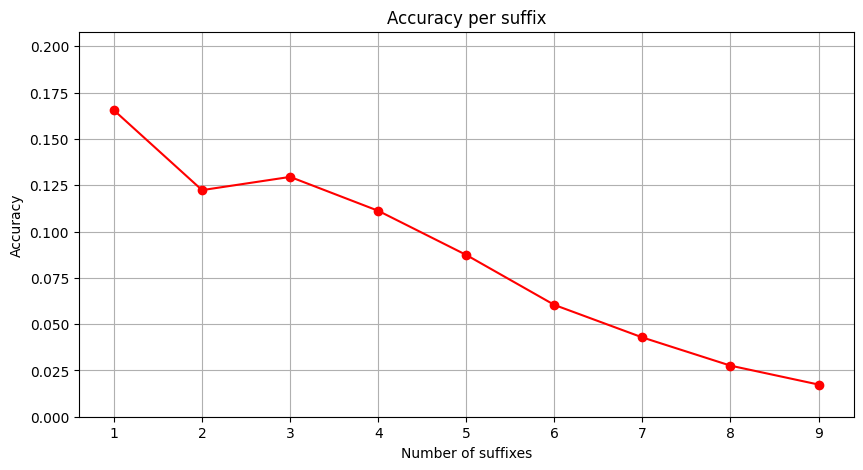

In [78]:
best_sufix_length = np.argmax(suffix_accuracies[1:])
best_suffix_model = suffix_models[best_sufix_length + 1]
print(f"Best suffix length: {best_sufix_length + 1}")

show_accuracy_table(suffix_accuracies, "Accuracy per suffix", ['Base TNT'] + [str(i) + ' suffixes' for i in range(1, len(suffix_accuracies))], True, False)
show_accuracy_graph(suffix_accuracies[1:],  "Accuracy per suffix", [str(i) for i in range(1, len(suffix_accuracies))], "Number of suffixes", False)

Validación del mejor número de sufijos

In [79]:
def cross_validate_tnt_affix(sentences, num_partitions, affix_tagger):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        tnt_tagger = tnt.TnT(unk=affix_tagger, Trained=True)
        tnt_tagger.train(train_data)
        
        accuracy = tnt_tagger.accuracy(test_data)
        accuracies.append(accuracy)
        print(f"Accuracy for partition {i}: {accuracy}")
        
    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

In [80]:
def cross_validate_base_tnt(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        tnt_tagger = tnt.TnT()
        tnt_tagger.train(train_data)
        
        accuracy = tnt_tagger.accuracy(test_data)
        accuracies.append(accuracy)
        print(f"Accuracy for partition {i}: {accuracy}")
        
    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)

    return accuracies

Best affix tagger with TNT

In [81]:
best_affix_tnt_accuracies = cross_validate_tnt_affix(cess_sents, 10, best_suffix_model)

Accuracy for partition 0: 0.9080366225839267
Accuracy for partition 1: 0.9093619558735838
Accuracy for partition 2: 0.9114793021575307
Accuracy for partition 3: 0.9101868280972759
Accuracy for partition 4: 0.9090708209037676
Accuracy for partition 5: 0.9043232115285641
Accuracy for partition 6: 0.9033637548891786
Accuracy for partition 7: 0.9127219705254387
Accuracy for partition 8: 0.9081149352699716
Accuracy for partition 9: 0.9016140639457181
Mean accuracy:  0.9078273465774955
Confidence interval:  (0.9052404245094936, 0.9104142686454975)


,Accuracy por fold,Accuracy
0,Fold 0,0.908037
1,Fold 1,0.909362
2,Fold 2,0.911479
3,Fold 3,0.910187
4,Fold 4,0.909071
5,Fold 5,0.904323
6,Fold 6,0.903364
7,Fold 7,0.912722
8,Fold 8,0.908115
9,Fold 9,0.901614


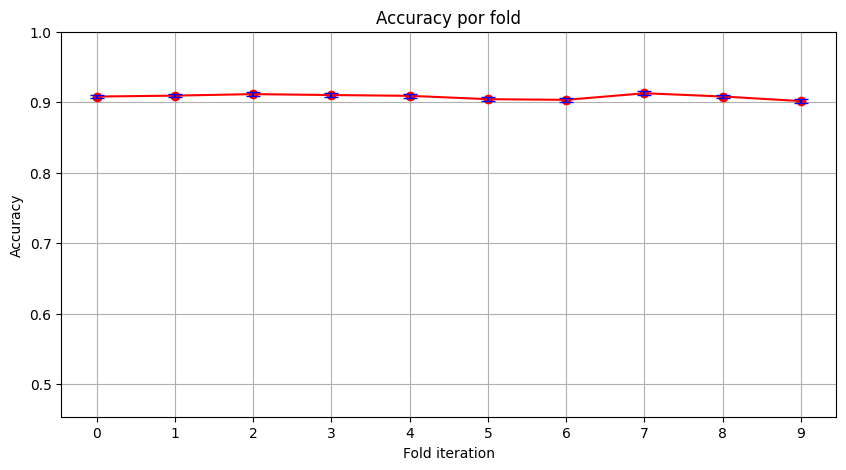

In [89]:
show_accuracy_table(best_affix_tnt_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(best_affix_tnt_accuracies))])
show_accuracy_graph(best_affix_tnt_accuracies, "Accuracy por fold", list(range(len(best_affix_tnt_accuracies))), "Fold iteration")

Base TNT tagger

In [83]:
base_tnt_accuracies = cross_validate_base_tnt(cess_sents, 10)

Accuracy for partition 0: 0.895676500508647
Accuracy for partition 1: 0.8976843569866826
Accuracy for partition 2: 0.8997625683906266
Accuracy for partition 3: 0.8966183070660683
Accuracy for partition 4: 0.8975251353441609
Accuracy for partition 5: 0.89233144621719
Accuracy for partition 6: 0.8902737940026075
Accuracy for partition 7: 0.9004842993282299
Accuracy for partition 8: 0.894905799389538
Accuracy for partition 9: 0.8878893800760769
Mean accuracy:  0.8953151587309828
Confidence interval:  (0.8924098252155673, 0.8982204922463982)


,Accuracy por fold,Accuracy
0,Fold 0,0.895677
1,Fold 1,0.897684
2,Fold 2,0.899763
3,Fold 3,0.896618
4,Fold 4,0.897525
5,Fold 5,0.892331
6,Fold 6,0.890274
7,Fold 7,0.900484
8,Fold 8,0.894906
9,Fold 9,0.887889


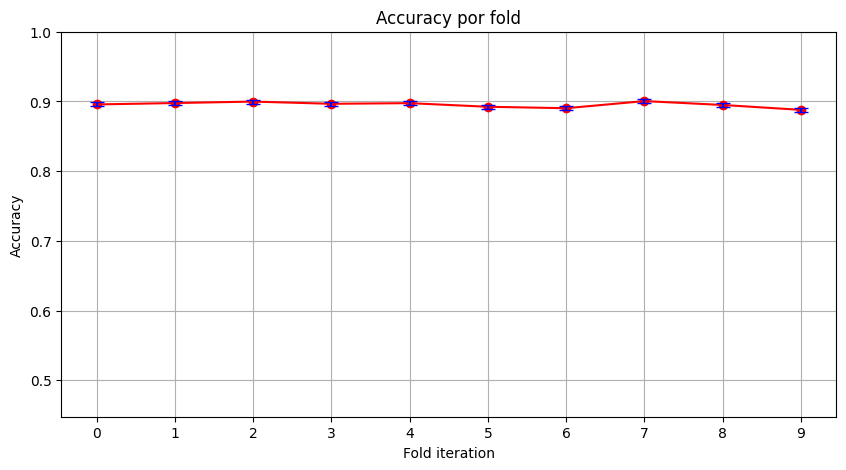

In [94]:
show_accuracy_table(base_tnt_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(base_tnt_accuracies))])
show_accuracy_graph(base_tnt_accuracies, "Accuracy por fold", list(range(len(base_tnt_accuracies))), "Fold iteration")

Comparación

In [85]:
def show_comparison_accuracy_graph(accuracies1, accuracies2, title, labels, x_label):
    plt.figure(figsize=(10, 5))

    acc_mean1 = np.mean(accuracies1)
    conf_int1 = stats.t.interval(0.95, len(accuracies1) - 1, loc=acc_mean1, scale=stats.sem(accuracies1))
    error_y1 = (conf_int1[1] - conf_int1[0]) / 2

    acc_mean2 = np.mean(accuracies2)
    conf_int2 = stats.t.interval(0.95, len(accuracies2) - 1, loc=acc_mean2, scale=stats.sem(accuracies2))
    error_y2 = (conf_int2[1] - conf_int2[0]) / 2

    min_acc = min(min(accuracies1), min(accuracies2))
    max_acc = max(max(accuracies1), max(accuracies2))
    plt.ylim(max(0, min_acc - 0.1), min(1, max_acc + 0.1))
    
    x = list(range(len(accuracies1)))
    plt.plot(x, accuracies1, 'ro-', label='Accuracy 1')
    plt.plot(x, accuracies2, 'bo-', label='Accuracy 2')
    
    plt.xticks(x, labels)
    plt.xlabel(x_label)
    plt.ylabel('Accuracy')
    plt.title(title)
    
    plt.errorbar(x, accuracies1, yerr=error_y1, linestyle='None', color='red', capsize=5)
    plt.errorbar(x, accuracies2, yerr=error_y2, linestyle='None', color='blue', capsize=5)

    plt.legend()
    plt.grid(True)
    plt.show()

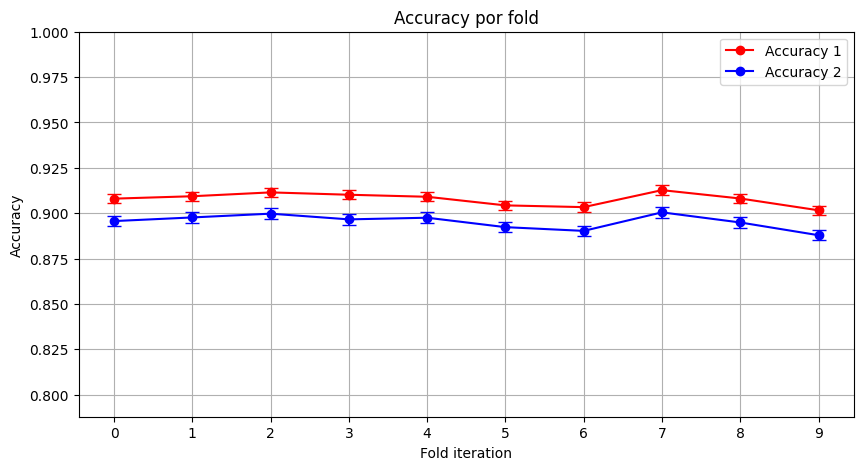

In [86]:
show_comparison_accuracy_graph(best_affix_tnt_accuracies, base_tnt_accuracies, "Accuracy por fold", list(range(len(best_affix_tnt_accuracies))), "Fold iteration")

## Ejercicio 4

Evaluación del resto de etiquetadores.


Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro 
como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los
etiquetadores tnt y hmm, utilizando el juego de categorías reducido. 

Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo 
probar con Unigram Tagger y con hmm tagger.

La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada 
requiere mucho tiempo

In [90]:
templates = brill.fntbl37()

### Brill

#### Unigram Tagger

Una sola partición

In [98]:
def validate_unigram_bill(sentences):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    unigram_tagger = UnigramTagger(train_data)
    brill_tagger_unigram = brill_trainer.BrillTaggerTrainer(unigram_tagger, templates, deterministic=True)
    brill_tagger_unigram = brill_tagger_unigram.train(train_data)

    accuracy = brill_tagger_unigram.accuracy(test_data)
    print(f"Accuracy: {acc}")

    return accuracy

In [99]:
unigram_bill_accuracy = validate_unigram_bill(reduced_cess_sents)

Accuracy: 0.01736718953115521


Múltiples particiones

In [100]:
def cross_validate_unigram_bill(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        unigram_tagger = UnigramTagger(train_data)
        brill_tagger_unigram = brill_trainer.BrillTaggerTrainer(unigram_tagger, templates, deterministic=True)
        brill_tagger_unigram = brill_tagger_unigram.train(train_data)

        acc = brill_tagger_unigram.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    mean_acc = np.mean(accuracies)
    conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
    print("Mean accuracy: ", mean_acc)
    print("Confidence interval: ", conf_int)
    
    return accuracies

In [101]:
unigram_bill_accuracies = cross_validate_unigram_bill(reduced_cess_sents, 10)

Accuracy for partition 0: 0.9024923702950153
Accuracy for partition 1: 0.9046909163188233
Accuracy for partition 2: 0.9053370496541757
Accuracy for partition 3: 0.9043419267299865
Accuracy for partition 4: 0.9032151143520053
Accuracy for partition 5: 0.8990221307256819
Accuracy for partition 6: 0.8977314211212516
Accuracy for partition 7: 0.9076186012602198
Accuracy for partition 8: 0.9025892011367225
Accuracy for partition 9: 0.8954456667009355
Mean accuracy:  0.9022484398294817
Confidence interval:  (0.8995619928283008, 0.9049348868306625)


,Accuracy por fold,Accuracy
0,Fold 0,0.902492
1,Fold 1,0.904691
2,Fold 2,0.905337
3,Fold 3,0.904342
4,Fold 4,0.903215
5,Fold 5,0.899022
6,Fold 6,0.897731
7,Fold 7,0.907619
8,Fold 8,0.902589
9,Fold 9,0.895446


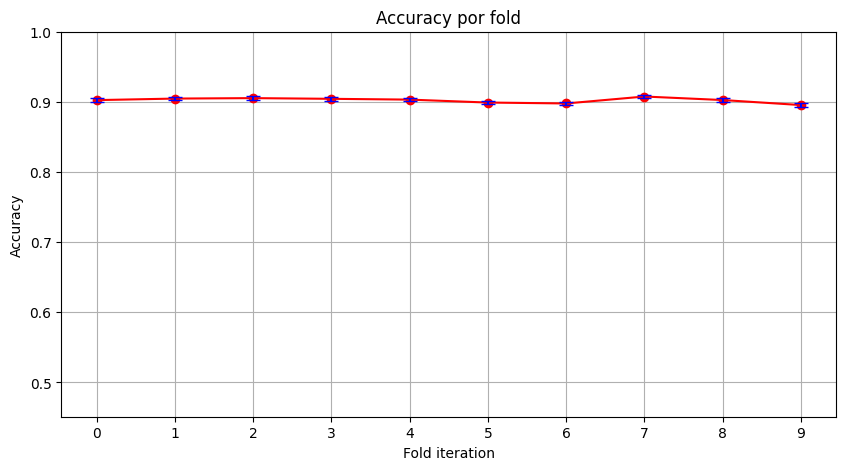

In [102]:
show_accuracy_table(unigram_bill_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(unigram_bill_accuracies))])
show_accuracy_graph(unigram_bill_accuracies, "Accuracy por fold", list(range(len(unigram_bill_accuracies))), "Fold iteration")

#### HNN Tagger

In [ ]:
def validate_hnn_bill(sentences):
    test_data, train_data = train_test_split(sentences, test_size=0.1)

    hmm_tagger = hmm.HiddenMarkovModelTagger.train(train_data)
    brill_tagger_hmm = brill_trainer.BrillTaggerTrainer(hmm_tagger, templates, deterministic=True)
    brill_tagger_hmm = brill_tagger_hmm.train(train_data)

    accuracy = brill_tagger_hmm.accuracy(test_data)
    print(f"Accuracy: {accuracy}")

Una sola partición

In [ ]:
hnn_bill_accuracy = validate_hnn_bill(reduced_cess_sents)

Múltiples particiones

In [ ]:
def cross_validate_hnn_bill(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        hmm_tagger = hmm.HiddenMarkovModelTagger.train(train_data)
        brill_tagger_hmm = brill_trainer.BrillTaggerTrainer(hmm_tagger, templates, deterministic=True)
        brill_tagger_hmm = brill_tagger_hmm.train(train_data)

        acc = brill_tagger_hmm.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    if num_partitions != 1:
        mean_acc = np.mean(accuracies)
        conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
        print("Mean accuracy: ", mean_acc)
        print("Confidence interval: ", conf_int)
        return accuracies
    else:
        return accuracies[0]

In [ ]:
hnn_bill_accuracies = cross_validate_hnn_bill(reduced_cess_sents, 10)

In [ ]:
show_accuracy_table(hnn_bill_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(hnn_bill_accuracies))])
show_accuracy_graph(hnn_bill_accuracies, "Accuracy por fold", list(range(len(hnn_bill_accuracies))), "Fold iteration")

### Perceptron

In [ ]:
def cross_validate_perceptron(sentences, num_partitions):
    partition_size = len(sentences) // num_partitions
    partitions = [sentences[i * partition_size: (i + 1) * partition_size] for i in range(num_partitions)]

    accuracies = []
    for i in range(num_partitions):
        test_data = partitions[i]
        train_data = [sentence for part_idx, partitions in enumerate(partitions) if part_idx != i for sentence in partitions]

        perceptron_tagger = PerceptronTagger(load=False)
        perceptron_tagger.train(train_data)

        acc = perceptron_tagger.accuracy(test_data)
        accuracies.append(acc)
        print(f"Accuracy for partition {i}: {acc}")

    if num_partitions != 1:
        mean_acc = np.mean(accuracies)
        conf_int = t.interval(0.95, len(accuracies) - 1, loc=mean_acc, scale=stats.sem(accuracies))
        print("Mean accuracy: ", mean_acc)
        print("Confidence interval: ", conf_int)
        return accuracies
    else:
        return accuracies[0]

Una partición

In [ ]:
perceptron_accuracy = cross_validate_perceptron(reduced_cess_sents, 1)

Precisión del etiquetador Perceptron: 0.9680


Múltiples particiones

In [ ]:
perceptron_accuracies = cross_validate_perceptron(reduced_cess_sents, 10)

In [ ]:
show_accuracy_table(perceptron_accuracies, "Accuracy por fold", ["Fold " + str(i) for i in range(len(perceptron_accuracies))])
show_accuracy_graph(perceptron_accuracies, "Accuracy por fold", list(range(len(perceptron_accuracies))), "Fold iteration")